In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py
import sys

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../')

In [4]:
import datatools

In [5]:
from glob import glob

In [6]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
SIM_LOC=f"{SIM}/20220901/SIG_atlas_nsw_pad_z0_bkgr_1_BKG_stgBkg20_stgMaxBkgHit1/"
DATA_LOC=f"{SIM_LOC}/TRAIN/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [7]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=2500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 200/200 [01:25<00:00,  2.34it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 500000/500000 [00:15<00:00, 31869.06it/s]

!!
I read 500000 events, of which 250000 have muon and 250000 do not
!!


In [8]:
(1-Y_mu).sum()

250000

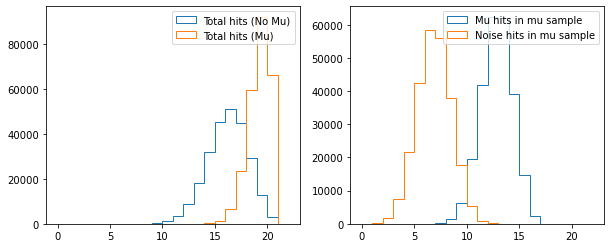

In [9]:
ncols, nrows = (2,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

axs[0].hist(data['ev_n_signals'][Y_mu==0], histtype='step', bins=22, range=(0,22), label='Total hits (No Mu)')
axs[0].hist(data['ev_n_signals'][Y_mu==1], histtype='step', bins=22, range=(0,22), label='Total hits (Mu)')
axs[0].legend()

axs[1].hist(data['ev_n_mu_signals'][Y_mu==1], histtype='step', bins=22, range=(0,22), label='Mu hits in mu sample')
axs[1].hist(data['ev_n_signals'][Y_mu==1]-data['ev_n_mu_signals'][Y_mu==1], histtype='step', bins=13, range=(0,13), label='Noise hits in mu sample')
axs[1].legend()

plt.show()

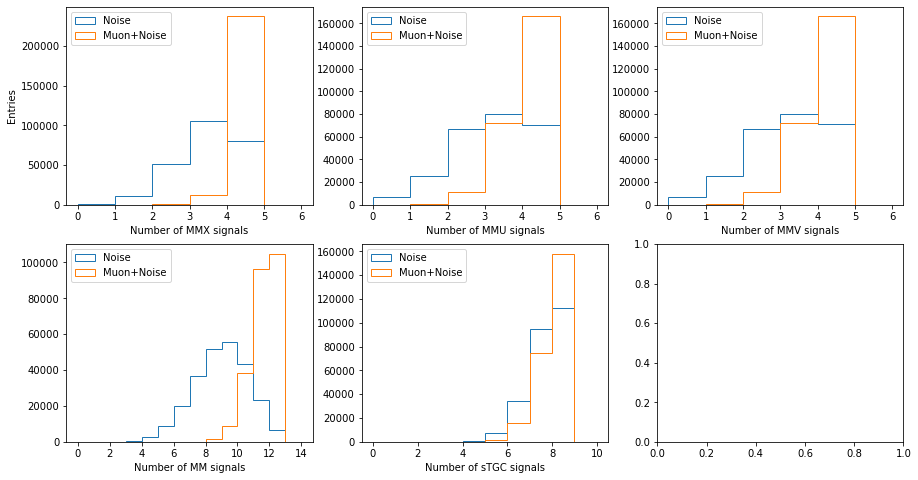

In [10]:
ncols, nrows = (3,2)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

axs[0].hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
axs[0].hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
axs[0].legend(loc='upper left')
axs[0].set_xlabel('Number of MMX signals')
axs[0].set_ylabel('Entries')

axs[1].hist(data['n_sig_mmu'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
axs[1].hist(data['n_sig_mmu'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Number of MMU signals')

axs[2].hist(data['n_sig_mmv'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
axs[2].hist(data['n_sig_mmv'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
axs[2].legend(loc='upper left')
axs[2].set_xlabel('Number of MMV signals')

axs[3].hist(data['n_sig_mm'][Y_mu==0], histtype='step', range=(0,14), bins=14, label='Noise')
axs[3].hist(data['n_sig_mm'][Y_mu==1], histtype='step', range=(0,14), bins=14, label='Muon+Noise')
axs[3].legend(loc='upper left')
axs[3].set_xlabel('Number of MM signals')

axs[4].hist(data['n_sig_stgc'][Y_mu==0], histtype='step', range=(0,10), bins=10, label='Noise')
axs[4].hist(data['n_sig_stgc'][Y_mu==1], histtype='step', range=(0,10), bins=10, label='Muon+Noise')
axs[4].legend(loc='upper left')
axs[4].set_xlabel('Number of sTGC signals')
# axs[4].set_yscale('log')

plt.show()

In [11]:
dmat.shape[2]

18

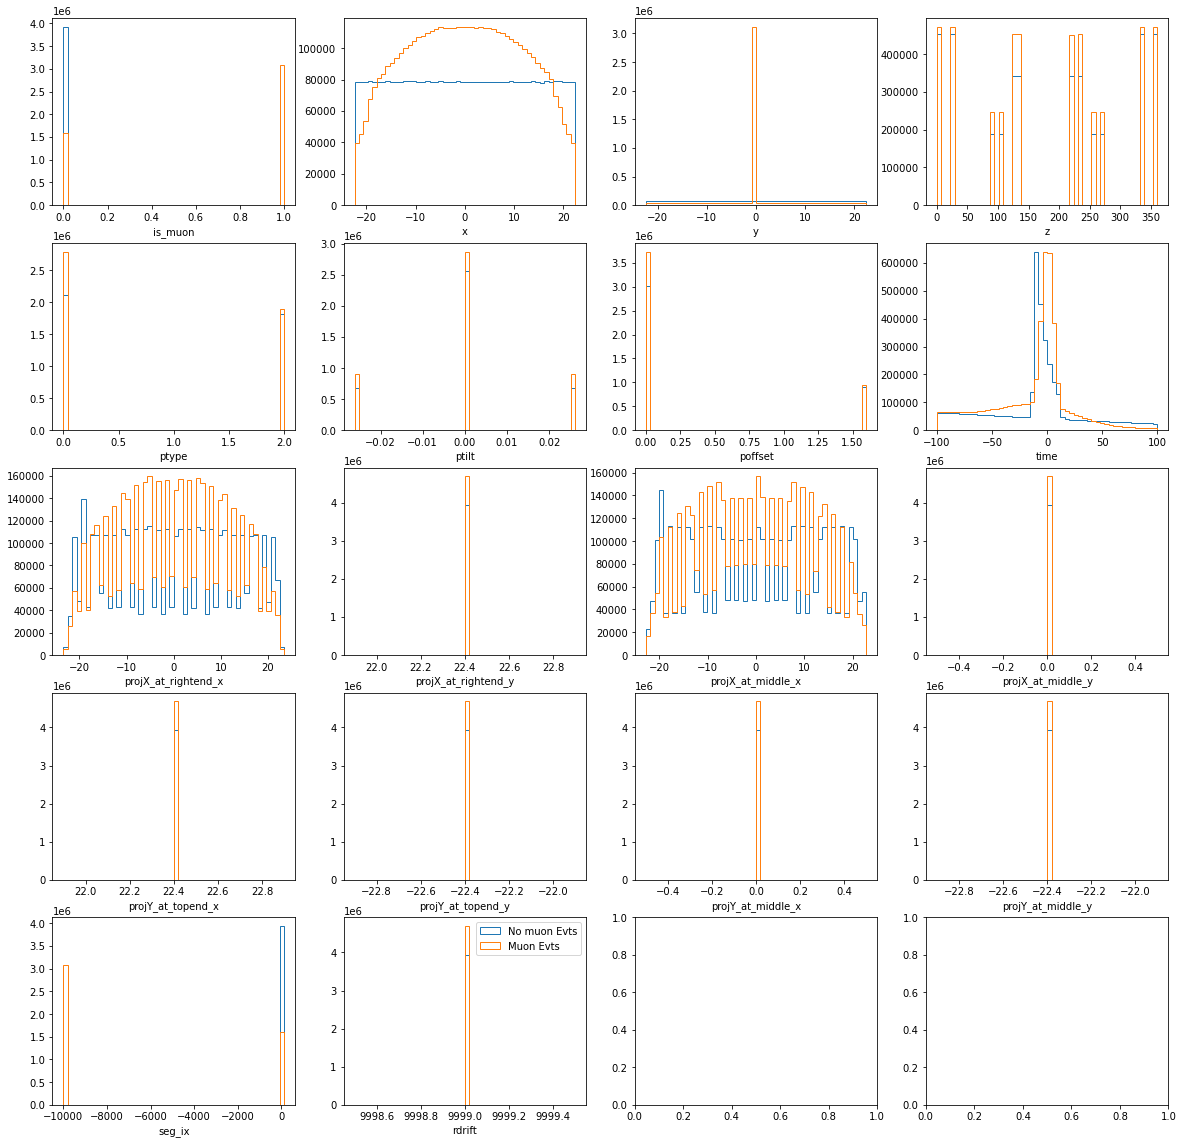

In [12]:
ncols=4
nrows=5
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

for ivar in range(dmat.shape[2]):

    valid_hits_mu   = dmat[Y_mu == 1,:,sig_keys.index('is_muon')].flatten() > -90
    valid_hits_nomu = dmat[Y_mu == 0,:,sig_keys.index('is_muon')].flatten() > -90

    this_var_mu   = dmat[Y_mu == 1,:,ivar].flatten()[valid_hits_mu]
    this_var_nomu = dmat[Y_mu == 0,:,ivar].flatten()[valid_hits_nomu]
    
    this_max = np.max([*this_var_mu, *this_var_nomu])
    this_min = np.min([*this_var_mu, *this_var_nomu])
        
    axs[ivar].hist( this_var_nomu, histtype='step', range=(this_min, this_max), bins=50, label = 'No muon Evts'  )
    axs[ivar].hist( this_var_mu, histtype='step', range=(this_min, this_max), bins=50, label = 'Muon Evts' )    

    axs[ivar].set_xlabel(sig_keys[ivar])
    
    if ivar == dmat.shape[2] - 1:
        axs[ivar].legend()
    
plt.show()

In [13]:
X_prep = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 500000/500000 [01:18<00:00, 6342.06it/s]

Output data matrix shape: (500000, 20, 20)


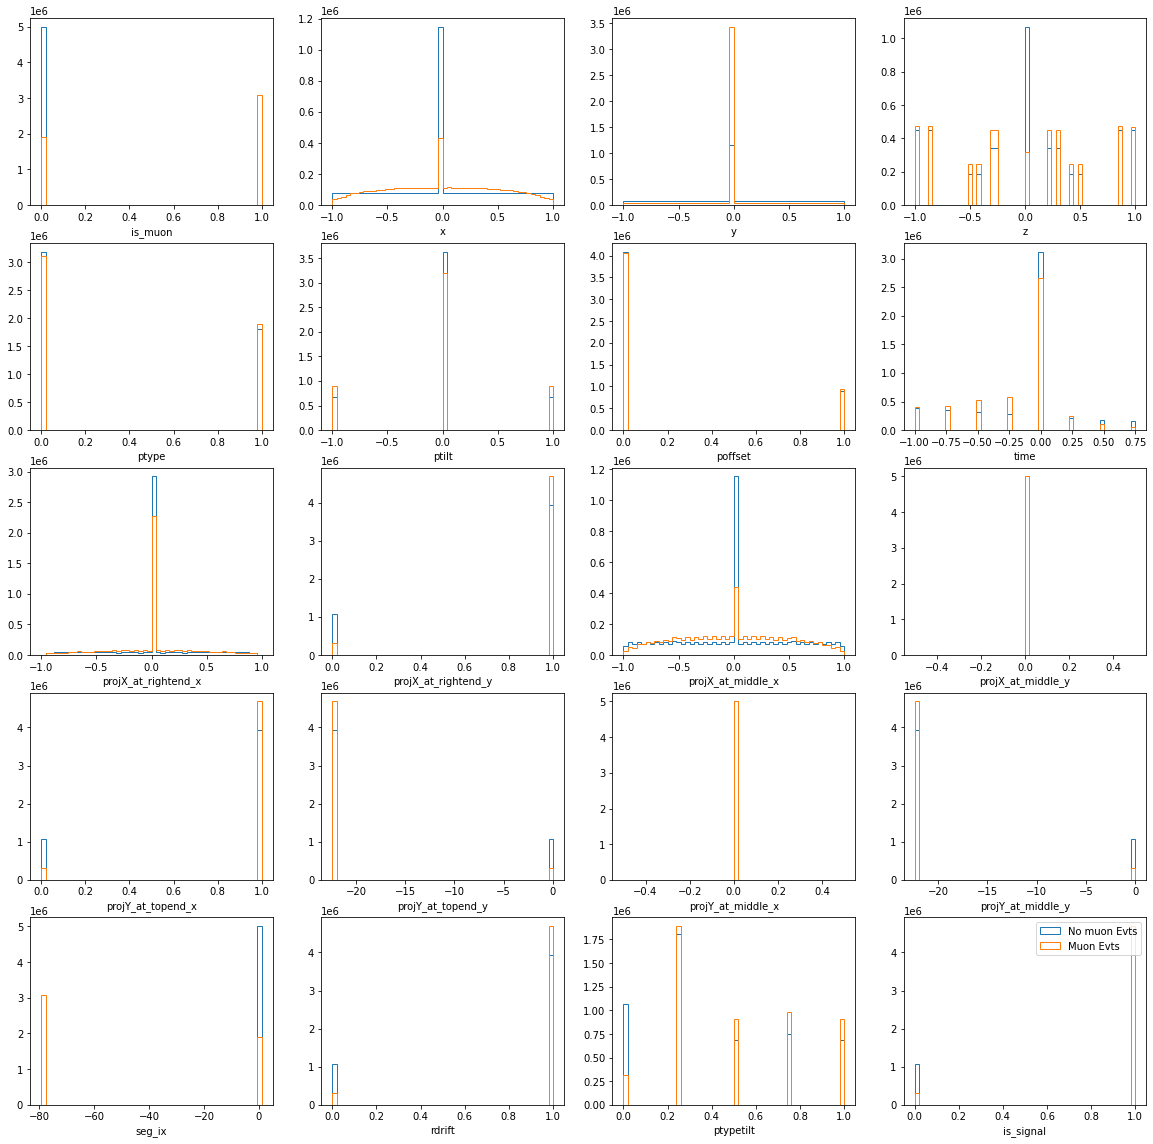

In [14]:
ncols=4
nrows=5
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

for ivar in range(X_prep.shape[2]):

    this_var_mu   = X_prep[Y_mu == 1,:,ivar].flatten()
    this_var_nomu = X_prep[Y_mu == 0,:,ivar].flatten()
    
    this_max = np.max([*this_var_mu, *this_var_nomu])
    this_min = np.min([*this_var_mu, *this_var_nomu])
        
    axs[ivar].hist( this_var_nomu, histtype='step', range=(this_min, this_max), bins=50, label = 'No muon Evts'  )
    axs[ivar].hist( this_var_mu, histtype='step', range=(this_min, this_max), bins=50, label = 'Muon Evts' )    

    axs[ivar].set_xlabel(sig_keys[ivar])
    
    if ivar == X_prep.shape[2] - 1:
        axs[ivar].legend()
    
plt.show()

In [15]:
import trainingvariables

In [16]:
vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
training_vars = trainingvariables.tvars
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1
X = X_prep[:,:,vars_of_interest]

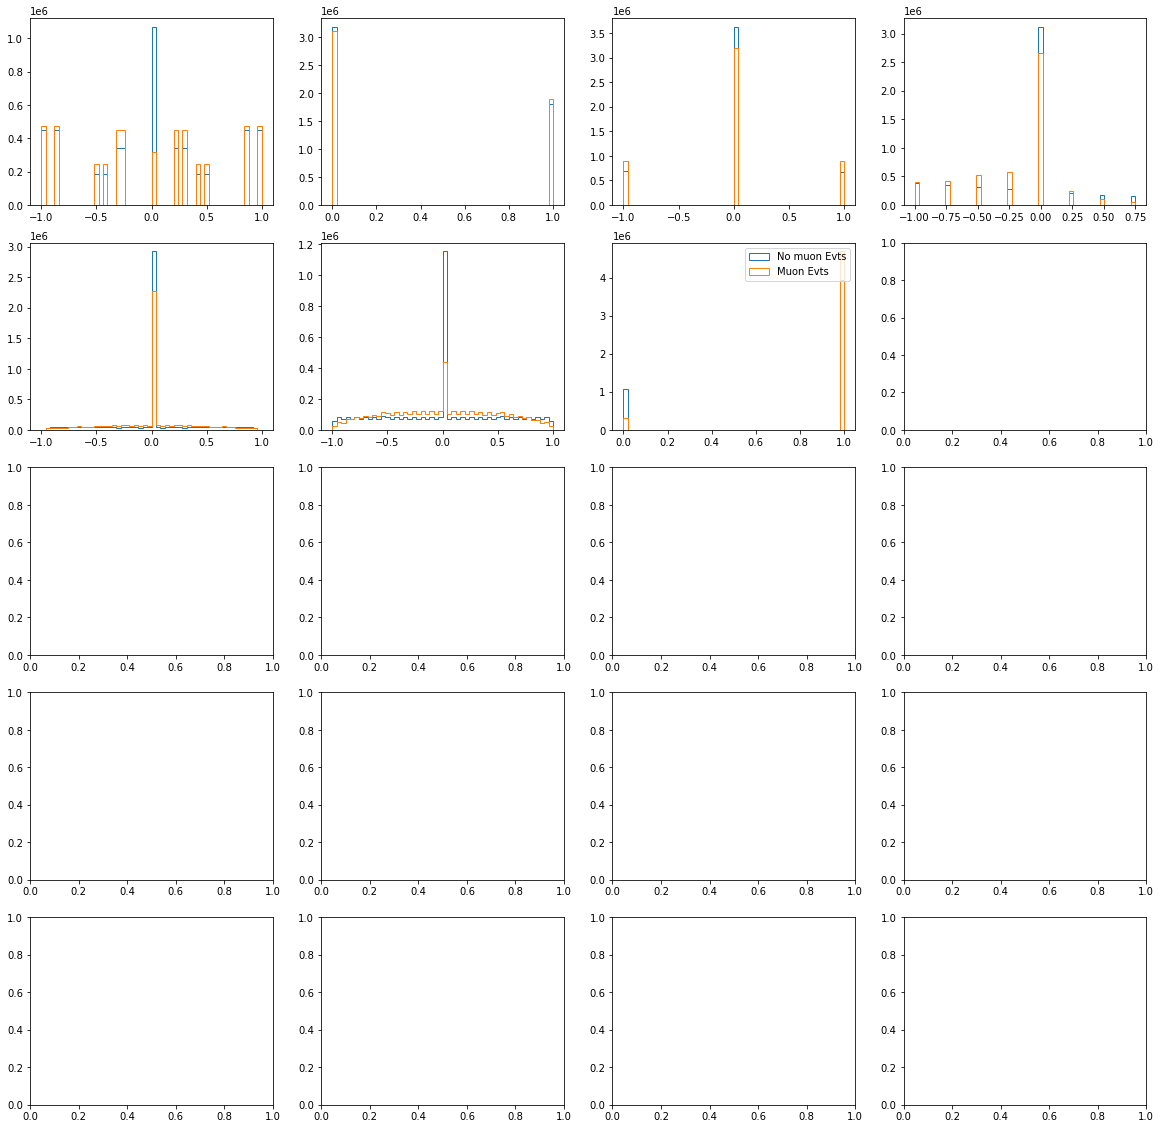

In [17]:
ncols=4
nrows=5
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

for ivar in range(X.shape[2]):

    this_var_mu   = X[Y_mu == 1,:,ivar].flatten()
    this_var_nomu = X[Y_mu == 0,:,ivar].flatten()
    
    this_max = np.max([*this_var_mu, *this_var_nomu])
    this_min = np.min([*this_var_mu, *this_var_nomu])
        
    axs[ivar].hist( this_var_nomu, histtype='step', range=(this_min, this_max), bins=50, label = 'No muon Evts'  )
    axs[ivar].hist( this_var_mu, histtype='step', range=(this_min, this_max), bins=50, label = 'Muon Evts' )    

    # axs[ivar].set_xlabel(sig_keys[ivar])
    
    if ivar == X.shape[2] - 1:
        axs[ivar].legend()
    
plt.show()

In [18]:
%ls $SIM_LOC

atlas_nsw_pad_z0.yml  TEST/  TRAIN/


In [19]:
X_det = datatools.detector_matrix(dmat, sig_keys, detcard=f"{SIM_LOC}/atlas_nsw_pad_z0.yml")

~~ Preparing detector-based data matrix ~~
Using detector card: /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation//20220901/SIG_atlas_nsw_pad_z0_bkgr_1_BKG_stgBkg20_stgMaxBkgHit1//atlas_nsw_pad_z0.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 500000/500000 [01:38<00:00, 5066.18it/s]

Output data matrix shape: (500000, 20, 20)


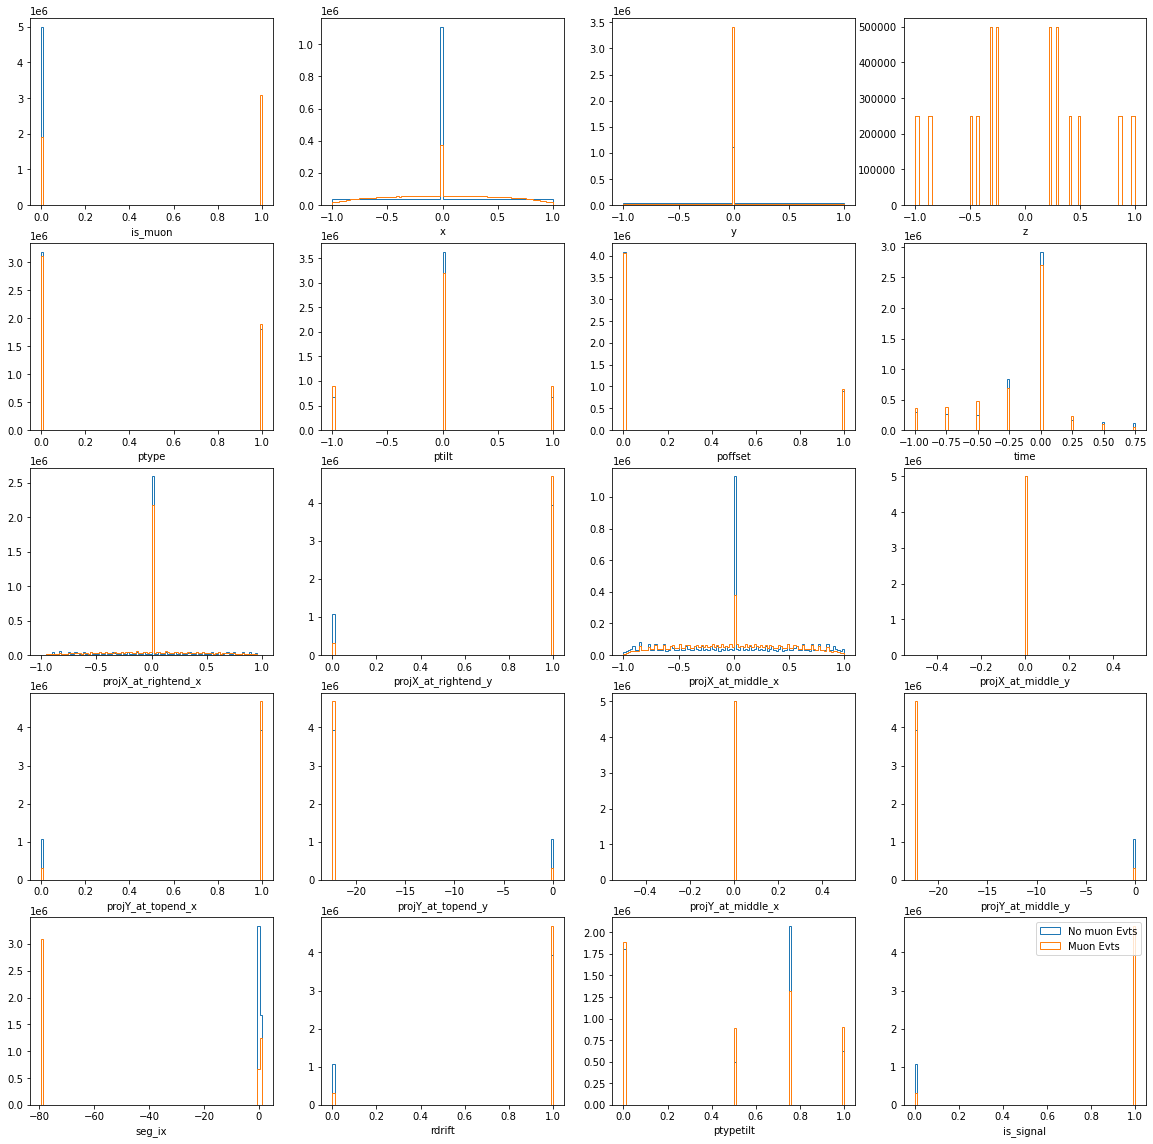

In [20]:
ncols=4
nrows=5
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

for ivar in range(X_det.shape[2]):

    this_var_mu   = X_det[Y_mu == 1,:,ivar].flatten()
    this_var_nomu = X_det[Y_mu == 0,:,ivar].flatten()
    
    this_max = np.max([*this_var_mu, *this_var_nomu])
    this_min = np.min([*this_var_mu, *this_var_nomu])
        
    axs[ivar].hist( this_var_nomu, histtype='step', range=(this_min, this_max), bins=100, label = 'No muon Evts'  )
    axs[ivar].hist( this_var_mu, histtype='step', range=(this_min, this_max), bins=100, label = 'Muon Evts' )    

    axs[ivar].set_xlabel(sig_keys[ivar])
    
    if ivar == X_det.shape[2] - 1:
        axs[ivar].legend()
    
plt.show()